# Qule
This notebook gives you a taste of what is happening behind the scenes of Qule, the quantum enhanced de novo drug design application. Run each cell in this notebook to generate a novel small molecule and evaluate its properties. 

First, we begin by importing all the libraries we require to run our model. The libraries required for this project can all be installed in one shot using the _requirements.txt_ file in this repo.

In [1]:
import pennylane as qml
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time
from frechetdist import frdist

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch

from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset
from rdkit import Chem

If the cell above runs without errors, it means you're good to go! Otherwise, you might have to check your setup and individually install the packages that are missing. For most cases, the command below should work. Replace _package-name_ with the package you need and run the command in a separate cell. 

In [4]:
# !pip install package-name

We're all set now! 

## Quantum GAN
Qule employs a quantum GAN (Generative Adversarial Network) to create novel small molecules. The quantum GAN consists of two parts - the Generator, and the Discriminator. In this implementation, we use a quantum generator and a classical discriminator. 

### Quantum Generator
The quantum generator is a parametrised variational quantum circuit. It takes as input uniformly sampled noise, and weights. Let us first define this quantum circuit. 

## Running on AWS Braket

The quantum generator can be run on the local simulator provided by AWS Braket as well as on real quantum hardware like IonQ, Rigetti, and DWave's devices that are accessible via Braket

In [2]:
# to run on braket, make the following imports 

# import boto3
# from braket.aws import AwsDevice

# and then include the following code - 

# device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
# or
# device_arn = "arn:aws:braket:::device/qpu/ionq/ionQdevice"

# dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=qubits)




In [3]:
def str2bool(v):
    return v.lower() in ('true')

qubits = 8

dev = qml.device('default.qubit', wires=qubits)

@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # random noise as generator input
    noise = torch.rand(qubits) * math.pi / 2
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1
    
    for i in range(qubits):
        qml.RX(np.arcsin(z1), wires = i)
        qml.RZ(np.arcsin(z2), wires = i)
        
        
    for i in range(qubits):
        for j in range(qubits):
            if i != j:
                qml.CNOT(wires=[i, j])
        #qml.RZ(w[i+qubits], wires=i+1)
        #qml.CNOT(wires=[i, i+1])

    for i in range(qubits):
        qml.RX(w[i], wires=i)
        qml.RZ(w[i], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]
    

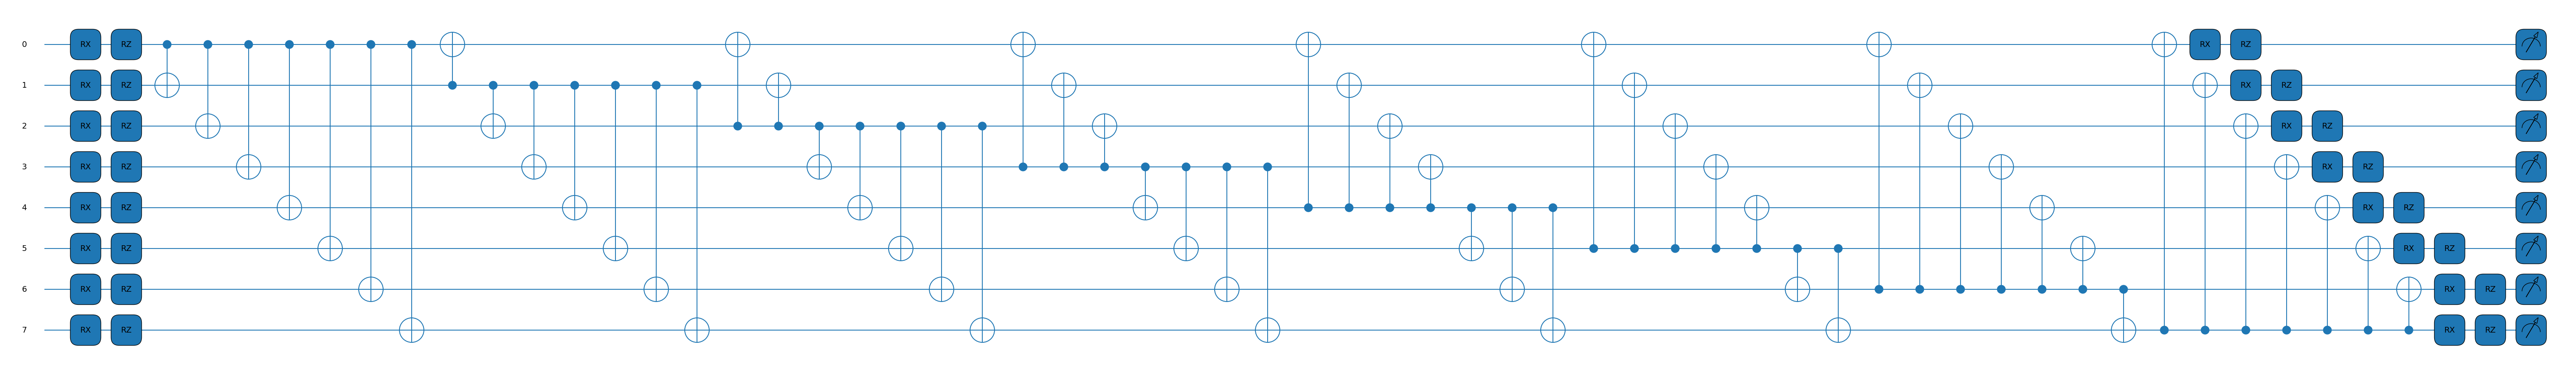

In [6]:
gen_weights = torch.tensor([-0.11443097,-0.23893048,-0.26079974,0.52572775,0.04154618,0.7797117,\
                                -0.22719051,0.04173521,-0.7405998,0.040963333,0.13625668,0.5491951,0.41576374,-0.059020802,0.7136884], requires_grad=True)
fig, ax = qml.draw_mpl(gen_circuit)(gen_weights)

In [8]:
parser = argparse.ArgumentParser()

# Quantum circuit configuration
parser.add_argument('--quantum', type=bool, default=True, help='choose to use quantum gan with hybrid generator')
#parser.add_argument('--patches', type=int, default=1, help='number of quantum circuit patches')
parser.add_argument('--patches', type=int, default=2, help='number of quantum circuit patches')
#parser.add_argument('--layer', type=int, default=1, help='number of repeated variational quantum layer')
parser.add_argument('--qubits', type=int, default=8, help='number of qubits and dimension of domain labels')
# parser.add_argument('--qubits', type=int, default=4, help='number of qubits and dimension of domain labels')

# Model configuration.
parser.add_argument('--z_dim', type=int, default=8, help='dimension of domain labels')
parser.add_argument('--g_conv_dim', default=[128], help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]], help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

# Training configuration.
parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=5000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=2500, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

# Test configuration.
parser.add_argument('--test_iters', type=int, default=5000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

# Directories.
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='qgan-hg/logs')
parser.add_argument('--model_save_dir', type=str, default='qgan-hg/models')
parser.add_argument('--sample_dir', type=str, default='qgan-hg/samples')
parser.add_argument('--result_dir', type=str, default='qgan-hg/results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=1000)
parser.add_argument('--lr_update_step', type=int, default=500)

config = parser.parse_known_args()[0]
#print(config)

In [9]:
self = Solver(config)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 59202
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tanh_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Tanh()
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=128, out_feature

Loading the trained models from step 2580...


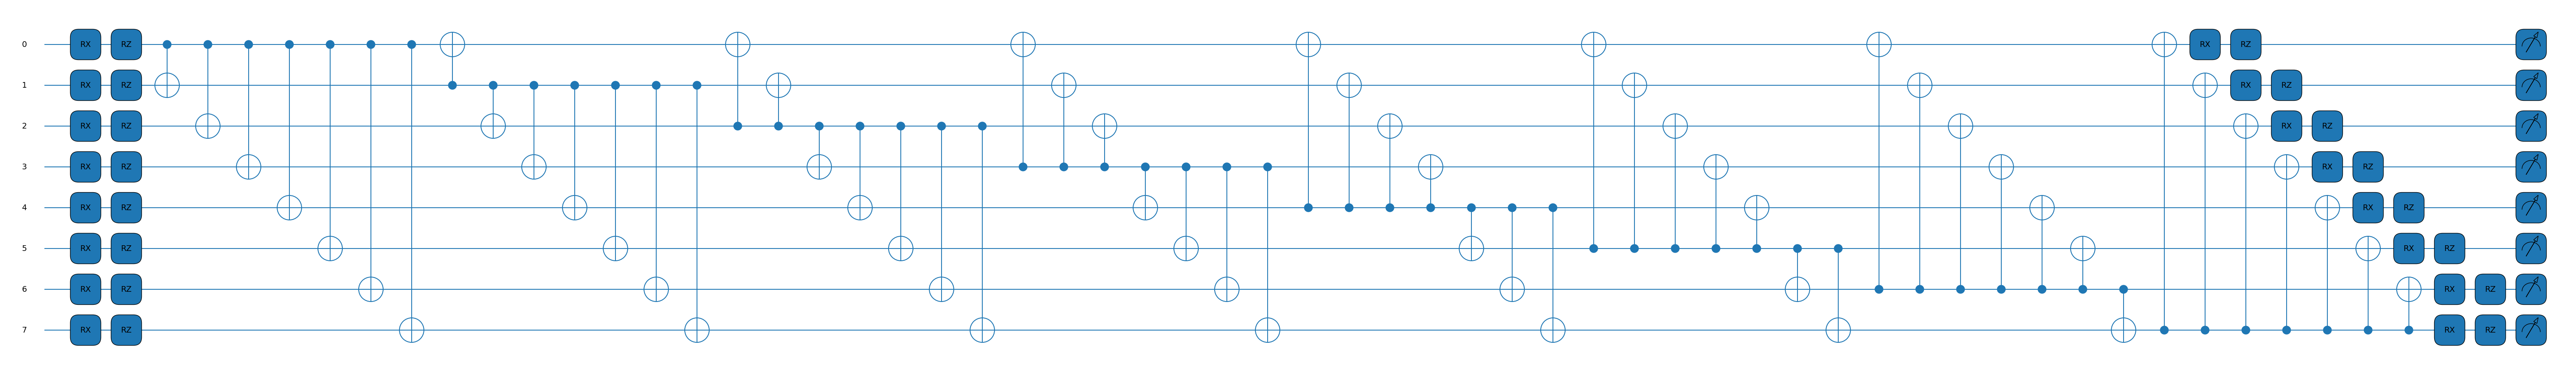

In [13]:
# Inference of generated molecules
start_iters = 0
self.resume_iters = 2580

if self.resume_iters:
    start_iters = self.resume_iters
    self.restore_model(self.resume_iters)
    gen_weights = torch.tensor([-0.11443097,-0.23893048,-0.26079974,0.52572775,0.04154618,0.7797117,\
                                -0.22719051,0.04173521,-0.7405998,0.040963333,0.13625668,0.5491951,0.41576374,-0.059020802,0.7136884], requires_grad=True)
    

ibm_sample_list = []
for i in range(self.batch_size):
    Running time depends on the queue of IBM melbourne machine
    if demo_on_ibmq:
        print("IBM Q running job {}/{}".format(i+1, self.batch_size), end="\r")
    ibm_sample_list.append(gen_circuit(gen_weights))
fig, ax = qml.draw_mpl(gen_circuit)(gen_weights)

In [ ]:
# Start inference.
print('Start inference...')
start_time = time.time()

mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)

# =================================================================================== #
#                             1. Preprocess input data                                #
# =================================================================================== #

a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
x = torch.from_numpy(x).to(self.device).long()            # Nodes.
a_tensor = self.label2onehot(a, self.b_dim)
x_tensor = self.label2onehot(x, self.m_dim)
z = torch.stack(tuple(ibm_sample_list)).to(self.device).float()

# Z-to-target
edges_logits, nodes_logits = self.G(z)
# Postprocess with Gumbel softmax
(edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
g_loss_fake = - torch.mean(logits_fake)

# Real Reward
rewardR = torch.from_numpy(self.reward(mols)).to(self.device)
# Fake Reward
(edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
        for e_, n_ in zip(edges_hard, nodes_hard)]
rewardF = torch.from_numpy(self.reward(mols)).to(self.device)

# Value loss
value_logit_real,_ = self.V(a_tensor, None, x_tensor, torch.sigmoid)
value_logit_fake,_ = self.V(edges_hat, None, nodes_hat, torch.sigmoid)
g_loss_value = torch.mean((value_logit_real - rewardR) ** 2 + (
                           value_logit_fake - rewardF) ** 2)

R=[list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_only = frdist(R, F)

R=[list(x[i]) + list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(nodes_hard[i]) + list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_atom = frdist(R, F)

loss = {}
loss['G/loss_fake'] = g_loss_fake.item()
loss['G/loss_value'] = g_loss_value.item()
loss['FD/fd_bond_only'] = fd_bond_only
loss['FD/fd_bond_atom'] = fd_bond_atom



In [10]:
# Print out training information.
et = time.time() - start_time
et = str(datetime.timedelta(seconds=et))[:-7]
log = "Elapsed [{}], Iteration [{}/{}]".format(et, start_iters, self.num_iters)

# Log update
m0, m1 = all_scores(mols, self.data, norm=True)     # 'mols' is output of Fake Reward
m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
m0.update(m1)
loss.update(m0)
for tag, value in loss.items():
    log += ", {}: {:.4f}".format(tag, value)
print(log)


Elapsed [0:00:04], Iteration [2580/5000], G/loss_fake: -0.8716, G/loss_value: 0.0447, FD/fd_bond_only: 13.8564, FD/fd_bond_atom: 14.2478, NP score: 0.7535, QED score: 0.5066, logP score: 0.5082, SA score: 0.2994, diversity score: 1.0000, drugcandidate score: 0.3888, valid score: 75.0000, unique score: 83.3333, novel score: 100.0000


RDKit ERROR: [23:40:05] Explicit valence for atom # 3 F, 2, is greater than permitted
[23:40:05] Explicit valence for atom # 3 F, 2, is greater than permitted
RDKit ERROR: [23:40:05] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [23:40:05] Explicit valence for atom # 7 F, 2, is greater than permitted
[23:40:05] Explicit valence for atom # 7 O, 3, is greater than permitted
[23:40:05] Explicit valence for atom # 7 F, 2, is greater than permitted


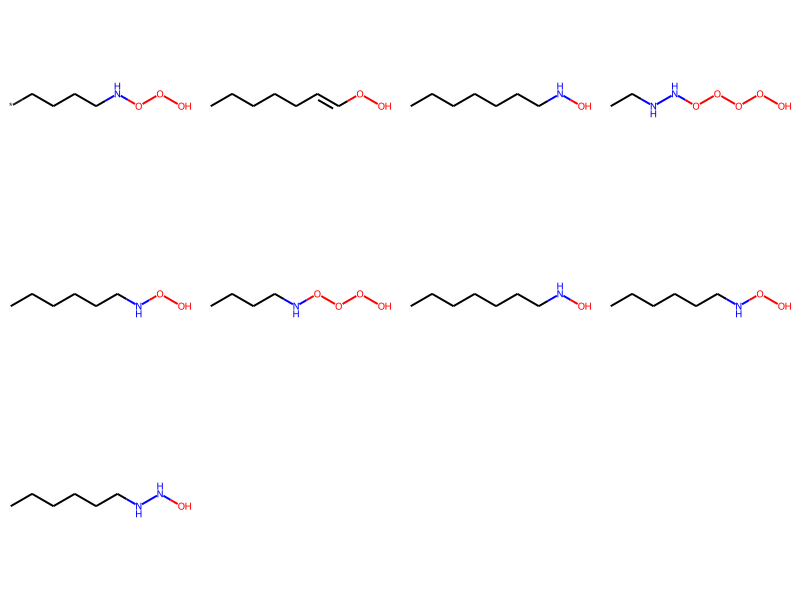

In [32]:
# Keep only valid moleculues evaluated by RDKit
mol1 = []
s=[]
smiles = []
for mol in mols:
    if mol is not None:            
        s.append(Chem.MolToSmiles(mol))
        
for smi in s:
    if smi is not None:            
        smiles.append(smi.replace('.',''))
        
for i in smiles: 
        mol1.append(Chem.MolFromSmiles(i))


valid_mols = [i for i in mol1 if i != None]



from rdkit.Chem.Draw import SimilarityMaps
import matplotlib

for mol in valid_mols:
    #AllChem.ComputeGasteigerCharges(mol)
    #contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    #fig = Draw.MolToImage(mol)
    #fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)
    #plt.savefig('newModel/trial2.png')
    img = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200))
img

    #print(mol)

# Drug scores


In [15]:
from utils import MolecularMetrics as mm
m1 = MolecularMetrics.quantitative_estimation_druglikeness_scores(valid_mols)

m2 = mm.water_octanol_partition_coefficient_scores(valid_mols)
m3 = mm.synthetic_accessibility_score_scores(valid_mols)
m4 = mm.natural_product_scores(valid_mols)


In [30]:
# Quantitative estimation druglikeness scores
print(m1)

array([0.30691885, 0.26805378, 0.42622351, 0.25543912, 0.32801852,
       0.31942239, 0.42622351, 0.32801852, 0.37366651])

In [31]:
# Solubility scores
print(m2)

array([ 0.66  ,  2.57  ,  1.9356, -0.7001,  1.5609,  0.6439,  1.9356,
        1.5609,  1.0501])

In [18]:
# Synthetic accessibility scores
print(m3)

array([4.67442924, 2.8974637 , 2.14586678, 4.40286739, 2.7281917 ,
       3.3914557 , 2.14586678, 2.7281917 , 2.72596524])

In [19]:
#Natural product scores
print(m4)

array([0.92302813, 2.031353  , 0.36176395, 0.73816449, 0.98779346,
       1.04710593, 0.36176395, 0.98779346, 0.24185492])